# Atividade 1 
Neste trabalho, você terá que entregar um notebook (preferencialmente, um link para um Colab) que implementa um auto-encoder. Para isso:

- Assista aos vídeos de Perceptron e MLP feitos só com numpy. Sua implementação deve seguir o que está lá, porém...
- Sua implementação deve permitir o usuário definir a arquitetura, ou seja, quantas camadas e quantos neurônios em cada uma delas eu vou querer usar. Explique no notebook como é o formato para eu definir isso.
- O notebook deve ter seções e textos explicativos. Ou seja, deve have uma documentação interna.
- Eu testarei com dados sintéticos, como os feitos para as aulas de Perceptron e MLP na prática. Porém, serão melhores (mais atributos, mais intersecção entre os "blobs", etc).


Grupo:

| Nome          | nUSP     |
|---------------|----------|
| Rafael Zimmer | 12542612 |
| Murilo Soave  | 10688813 |

In [22]:
from abc import ABC, abstractmethod
from typing import List

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

mersenne = lambda idx: int(np.power(2, 32) * np.sin(idx + 1))
np.random.seed(mersenne(1))

## Gerando o conjunto de dados:

Vamos criar um conjunto de dados sintético para testar o multi-layer perceptron.
Para a atividade, vamos definir uma estrutura que permita multiplas classes e multiplas colunas.

--------------------------------------------
### Função generate_class(mu, sigma, n)
Essa função gera dados para uma única classe com base nos parâmetros fornecidos:

* mu: a média da distribuição normal que define a classe.
* sigma: o desvio padrão da distribuição normal que define a classe.
* n: o número de observações a serem geradas.

A função numpy.random.normal() é usada para gerar os dados de acordo de uma forma estável com a distribuição normal, retornando um array com n observações.

--------------------------------------------

### Função generate_data(classes)
Essa função gera dados para várias classes, onde cada classe é definida por um conjunto de parâmetros.

* classes: um dicionário onde as chaves representam os rótulos das classes e os valores são tuplas contendo o número de observações (n) e uma lista de pares (mu, sigma) representando os parâmetros da distribuição normal para cada coluna.
A função itera sobre as classes fornecidas, gerando dados para cada uma delas usando a função generate_class(). Em seguida, concatena os dados gerados para todas as classes e adiciona codificação one-hot para os rótulos das classes. Por fim, embaralha os dados e os retorna.

Em suma, esses dois métodos servem para facilitar gerar distribuições de dados separáveis e não separáveis para testar o MLP. 

--------------------------------------------

In [23]:
def generate_class(mu, sigma, n):
    return np.random.normal(mu, sigma, n)


def generate_dataset(classes):
    data = []
    for label, params in classes.items():
        n, columns = params

        observations = []

        for mu, sigma in columns:
            observations.append(generate_class(mu, sigma, n))

        observations = np.array(observations).T
        # one hot encoding
        y_true = np.zeros((n, len(classes)))
        y_true[:, label] = 1

        data.append(np.concatenate([observations, y_true], axis=1))

    sorted_data = np.concatenate(data, axis=0)

    return np.random.permutation(sorted_data)

## Visualizando o conjunto de dados

Para facilitar a visualização, vamos gerar dados com apenas 2 dimensões. Cada classe é representada por uma cor diferente.

Input features: 2
Output features: 3


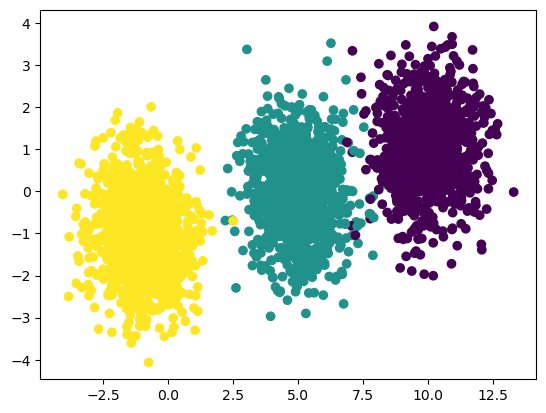

In [24]:
classes = {
    0: (1000, [(10, 1), (1, 1)]),
    1: (1000, [(5, 1), (0, 1)]),
    2: (1000, [(-1, 1), (-1, 1)]),
}

dataset = generate_dataset(classes)
input_features = dataset.shape[1] - len(classes)
output_features = len(classes)

print(f"Input features: {input_features}")
print(f"Output features: {output_features}")

x = dataset[:, :input_features]
y = dataset[:, input_features:]

plt.scatter(x[:, 0], x[:, 1], c=np.argmax(y, axis=1))

## Definindo uma Loss function

Essas classes são utilizadas para definir e calcular os erros dos modelos, especificamente a Cross Entropy, comum para problemas de classificação multiclasse.

------------------------------------
### Classe MSE
Essa classe implementa a função de _Mean Squared Error_, que parte da diferença entre as previsões e os rótulos verdadeiros, eleva ao quadrado e calcula a média.

__call__(self, y_true, y_pred): Calcula a perda com base no y_pred e nos _labels_ verdadeiros.

gradient(self, y_true, y_pred): Utilizado para retornar o gradiente calculado.

Em suma, a função MSE é uma função de perda comum para problemas de regressão, onde o objetivo é minimizar a diferença entre as previsões e os rótulos verdadeiros.

------------------------------------

In [25]:
class Module(ABC):
    def __call__(self, x):
        return self.forward(x)

    def pred(self, x):
        return np.argmax(self.forward(x))

    @abstractmethod
    def forward(self, x):
        pass

    @abstractmethod
    def backward(self, grad, lr=0.01):
        pass

In [54]:
class Loss(ABC):
    @abstractmethod
    def __call__(self, y_true, y_pred):
        pass

    @abstractmethod
    def gradient(self, y_true, y_pred):
        pass


class MSE(Loss):
    def __call__(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    def gradient(self, y_true, y_pred):
        return y_pred - y_true
    

class Tanh(Module):
    def forward(self, x):
        return np.tanh(x)

    def backward(self, grad, lr=0.01):
        return 1 - np.tanh(grad) ** 2


class ReLU(Module):
    def forward(self, x):
        return np.maximum(0, x)

    def backward(self, grad, lr=0.01):
        return np.where(grad > 0, 1, 0)


class Sigmoid(Module):
    def forward(self, x):
        return 1 / (1 + np.exp(-x))

    def backward(self, grad, lr=0.01):
        return grad * (1 - grad)


class Softmax(Module):
    # it is not batched so, it is just a single vector, not a matrix
    def forward(self, x):
        exps = np.exp(x - np.max(x))
        return exps / np.sum(exps)

    def backward(self, grad, lr=0.01):
        return grad * (1 - grad)

In [27]:
tan = Tanh()
relu = ReLU()
x = np.array([-1, 0, 1, 2, 3])
print(f"x, tanh(x): {x} -> {tan(x)}")
print(f"x, relu(x): {x} -> {relu(x)}")
print(f"x, softmax(x): {x} -> {Softmax()(x)}")

x, tanh(x): [-1  0  1  2  3] -> [-0.76159416  0.          0.76159416  0.96402758  0.99505475]
x, relu(x): [-1  0  1  2  3] -> [0 0 1 2 3]
x, softmax(x): [-1  0  1  2  3] -> [0.01165623 0.03168492 0.08612854 0.23412166 0.63640865]


In [28]:
criterion = MSE()
y_true = np.random.randn(output_features)
y_pred = np.random.randn(output_features)

loss = criterion(y_true, y_pred)
grad = criterion.gradient(y_true, y_pred)

print(f"Loss: {loss}")
print(f"Gradient: {grad}")

Loss: 4.22296857451025
Gradient: [1.14783294 3.1509345  1.1928944 ]


## Implementando o MLP em si

Classe MLP (_Multi-Layer Perceptron_):

* __init__(self, layers): O construtor inicializa os parâmetros da rede neural com base nas camadas fornecidas. _layers é uma lista que especifica o número de neurônios em cada camada.
* forward(self, x): Realiza a operação de feedforward na rede neural, aplicando a função de ativação camada à camada. É em essência um loop de produtos matriciais com pesos e passe das ativações (tornando o modelo não linear).
* backward(self, grad, lr=0.01): Faz o _backpropagation_ do gradiente na rede neural, atualizando os pesos e os viéses com base no gradiente descendente estocástico (SGD). (O valor grad é o gradiente da função de _loss_ em relação à saída da rede neural).
* pred(self, x=None, value=None): Retorna o y_hat da rede neural com base nas entradas fornecidas x ou em valores value.

Essa classe é uma implementação simples do que será utilizado para um exemplo de Autoencoder no final, com hidden layers não simétricas.

In [29]:
class Linear(Module):  # Fully connected layer
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weights = np.random.randn(in_features, out_features)
        self.biases = np.random.randn(out_features)

        self.x = None

    def forward(self, x):
        self.x = x
        return np.dot(x, self.weights) + self.biases

    def backward(self, grad, lr=0.01):
        grad_x = np.dot(grad, self.weights.T)
        grad_w = np.dot(self.x.T, grad)
        grad_b = np.sum(grad, axis=0)

        self.weights -= lr * grad_w
        self.biases -= lr * grad_b

        return grad_x


class Sequential(Module):
    def __init__(self, layers: List[Module]):
        super().__init__()

        self.layers = layers

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def backward(self, grad, lr=0.01):
        for layer in reversed(self.layers):
            grad = layer.backward(grad, lr=lr)
        return grad

## Testando o _backpropagation_

Vamos testar o _backpropagation_ em uma rede neural simples com uma camada linear e uma função de erro _MSE_.

In [30]:
criterion = MSE()

input_features = dataset.shape[1] - len(classes)
output_features = len(classes)

x = dataset[0, :input_features].reshape(1, -1)
y = dataset[0, input_features:]

linear = Linear(input_features, output_features)
mlp = Sequential([
    Linear(input_features, 6),
    Tanh(),
    Linear(6, output_features),
    Softmax(),
])

In [31]:
y_pred = linear(x)
loss = criterion(y, y_pred)

print(f"Weights: {linear.weights}")
print(f"Loss: {loss}")
grad = criterion.gradient(y, y_pred)
linear.backward(grad, lr=0.01)
print(f"Weights: {linear.weights}")
print(f"Loss: {criterion(y, linear(x))}")

y_pred = mlp(x)
loss = criterion(y, y_pred)

print(f"Loss (MLP): {criterion(y, mlp(x))}")
grad = criterion.gradient(y, y_pred)
mlp.backward(grad, lr=0.01)
print(f"Loss (MLP): {criterion(y, mlp(x))}")

Weights: [[-1.4011987   0.23066847 -0.71049833]
 [ 0.66987946 -0.85637925  1.00984585]]
Loss: 25.15253918017359
Weights: [[-1.05221708  0.24734388 -0.5365162 ]
 [ 0.68526819 -0.85564393  1.01751778]]
Loss: 15.60740133934128
Loss (MLP): 0.34021417586735864
Loss (MLP): 0.3467328523417251


## Treinando o modelo

A função train(dataset, model, criterion, lr=1e-4, epochs=1000) é responsável por treinar o modelo de acordo com os dados fornecidos.
O treinamento é feito por meio de um loop de épocas, onde cada época é composta por um loop de iterações sobre o conjunto de dados, mas é importante notar que o grosso da implementação está no método backward da classe MLP (que é um SGD padrão).

In [32]:
def train(x_train, y_train, model: Module, criterion: Loss, lr: float, epochs: int = 1000):
    losses = [+np.inf]

    # Loop over epochs
    for epoch in tqdm(range(epochs)):
        epoch_loss = 0

        # For each epoch, iterate over the dataset and update the weights
        for x, y in zip(x_train, y_train):
            x = x.reshape(1, -1)
            y_pred = model(x)
            loss = criterion(y, y_pred)
            grad = criterion.gradient(y, y_pred)
            model.backward(grad, lr=lr)

            epoch_loss += loss

        if epoch % 50 == 0:
            losses.append(epoch_loss)
            print(f'Epoch {epoch} - Loss: {epoch_loss}')

        if np.abs(epoch_loss) < 1e-3 or np.isnan(epoch_loss) or np.abs(losses[-1] - losses[-2]) < 1e-6:
            break

    return losses

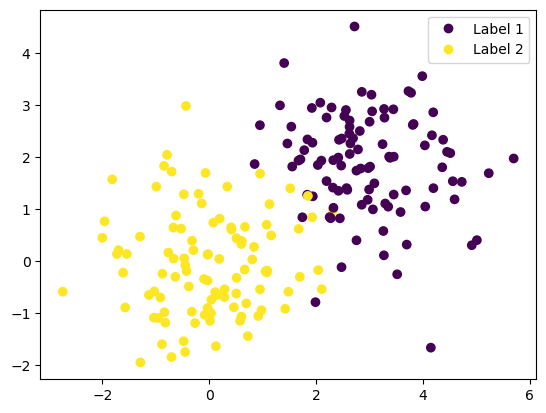

In [33]:
classes = {
    0: (100, [(3, 1), (2, 1)]),
    1: (100, [(0, 1), (0, 1)]),
}

dataset = generate_dataset(classes)
input_features = dataset.shape[1] - len(classes)
output_features = len(classes)

scatter = plt.scatter(dataset[:, 0], dataset[:, 1], c=np.argmax(dataset[:, 2:], axis=1))
plt.legend(handles=scatter.legend_elements()[0], labels=['Label 1', 'Label 2', 'Label 3', ...])
plt.show()

In [34]:
mlp = Sequential([
    Linear(input_features, 6),
    ReLU(),
    Linear(6, output_features),
    Softmax(),
])

criterion = MSE()

Loss: 81.77707046323404
Accuracy: 0.5


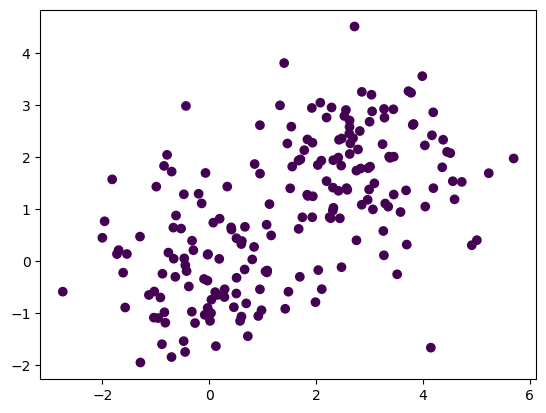

In [35]:
# Initial predictions
x = dataset[:, :input_features]
y = dataset[:, input_features:]

print(f"Loss: {np.sum([criterion(y, mlp(x)) for x, y in zip(x, y)])}")
print(f"Accuracy: {np.mean([np.argmax(y) == np.argmax(mlp(x)) for x, y in zip(x, y)])}")

plt.scatter(dataset[:, 0], dataset[:, 1], c=[mlp.pred(x) for x in dataset[:, :input_features]])

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0 - Loss: 69.81656425256686
Epoch 50 - Loss: 12.227430436933178
Epoch 100 - Loss: 6.645238458267105
Epoch 150 - Loss: 5.638151377424475
Epoch 200 - Loss: 5.29626808052939
Epoch 250 - Loss: 5.176792876640671
Epoch 300 - Loss: 5.161135217716975
Epoch 350 - Loss: 5.200479701765871
Epoch 400 - Loss: 5.266683865512027
Epoch 450 - Loss: 5.353346396441579
Epoch 500 - Loss: 5.454301050663932
Epoch 550 - Loss: 5.562938305833254
Epoch 600 - Loss: 5.695291588305399
Epoch 650 - Loss: 5.854814641427844
Epoch 700 - Loss: 6.042814076207377
Epoch 750 - Loss: 6.2801979248249955
Epoch 800 - Loss: 6.557136943107591
Epoch 850 - Loss: 6.850428933256244
Epoch 900 - Loss: 7.146942424414545
Epoch 950 - Loss: 7.401669874013397


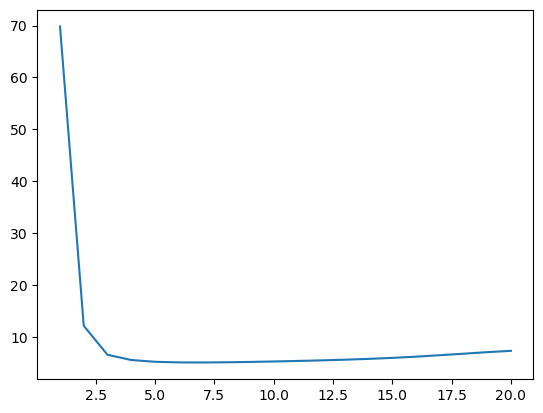

In [36]:
lr = 1e-3
epochs = 1000

losses = train(x, y, mlp, criterion, lr=lr, epochs=epochs)
plt.plot(losses)

Loss: 5.458000196322621
Accuracy: 0.965


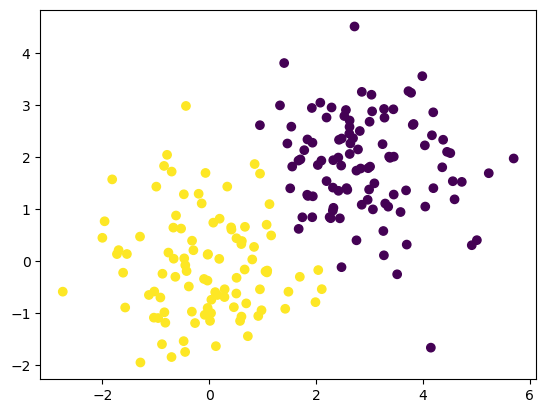

In [37]:
# Final predictions
print(f"Loss: {np.sum([criterion(y, mlp(x)) for x, y in zip(x, y)])}")
print(f"Accuracy: {np.mean([np.argmax(y) == np.argmax(mlp(x)) for x, y in zip(x, y)])}")

plt.scatter(dataset[:, 0], dataset[:, 1], c=[mlp.pred(x) for x in dataset[:, :input_features]])

## Autoencoder

Agora, vamos implementar um autoencoder, que é um tipo de rede neural que é treinada para copiar sua entrada para a saída. Ele é composto por duas partes: um codificador que transforma a entrada em uma representação interna e um decodificador que transforma a representação interna de volta na saída.

Aqui, vamos implementar um autoencoder simples com uma camada de entrada, uma camada oculta e uma camada de saída. O codificador e o decodificador são implementados como uma rede neural _feedforward_ com uma camada linear e uma função de ativação _tanh_.

In [89]:
class Autoencoder(Module):
    def __init__(self, layers: List[Module], output_layer: Module = None):
        super().__init__()

        self.encoder = Sequential(layers)
        decoder_layers = list(reversed(layers))

        if not isinstance(layers[-1], Linear):
            decoder_layers.pop(0)
            
        if output_layer is not None:
            decoder_layers.append(output_layer)

        self.decoder = Sequential([
            Linear(layer.weights.shape[1], layer.weights.shape[0]) if isinstance(layer, Linear) else layer
            for layer in decoder_layers
        ])

    @property
    def layers(self):
        return self.encoder.layers + self.decoder.layers

    def forward(self, x):
        return self.decoder(self.encoder(x))

    def backward(self, grad, lr=0.01):
        grad = self.decoder.backward(grad, lr=lr)
        return self.encoder.backward(grad, lr=lr)


In [110]:
# Now, for the autoencoder, we will try to generate the same data
# Our test dataset will be the MNIST image dataset
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)

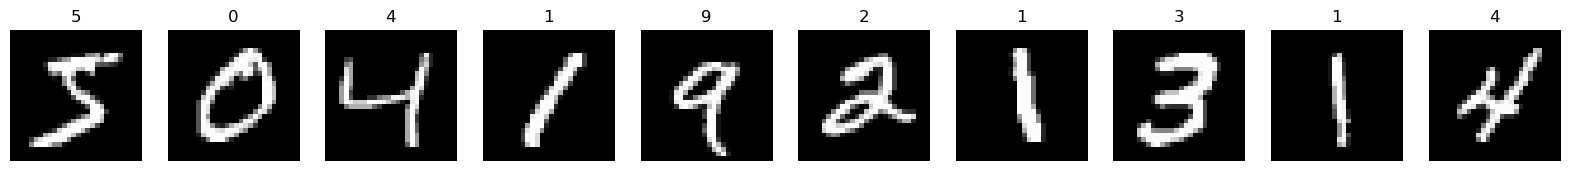

In [111]:
x = mnist.data
x_train = x.values

y = mnist.target
y_train = y.values

input_features = x.shape[1]
output_features = 10

# plot some images
fig, axes = plt.subplots(1, 10, figsize=(20, 2))

# x is a dataframe
for i, ax in enumerate(axes):
    image = x_train[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    ax.set_title(y_train[i])
    
plt.show()

In [113]:
autoencoder = Autoencoder([
    Linear(input_features, 256),
    ReLU(),
    Linear(256, 128),
    ReLU(),
    Linear(128, 32),
    ReLU(),
    Linear(32, 16),
    ReLU(),
    Linear(16, output_features),
    Tanh(),
])

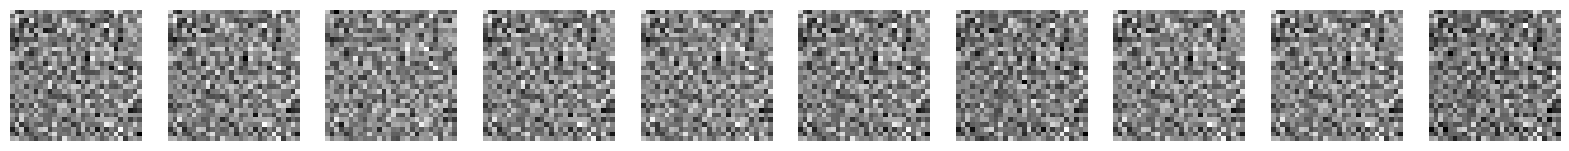

In [114]:
criterion = MSE()

# initial reconstructions
fig, axes = plt.subplots(1, 10, figsize=(20, 2))

for i, ax in enumerate(axes):
    x = x_train[i].reshape(1, -1)
    image = autoencoder(x).reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0 - Loss: 7.354796104380808e+49
Epoch 50 - Loss: 3.6516155254073343e+40
Epoch 100 - Loss: 1.6495569150438783e+36
Epoch 150 - Loss: 7.451600523211013e+31
Epoch 200 - Loss: 3.3661372851776714e+27
Epoch 250 - Loss: 1.520596841895201e+23
Epoch 300 - Loss: 6.869044722691544e+18
Epoch 350 - Loss: 310297731763118.9
Epoch 400 - Loss: 14017582077.587606
Epoch 450 - Loss: 1044785.2579960036
Epoch 500 - Loss: 411720.78525518905
Epoch 550 - Loss: 411692.923010348
Epoch 600 - Loss: 411692.9266943935
Epoch 650 - Loss: 411692.9267277802
Epoch 700 - Loss: 411692.9267280049


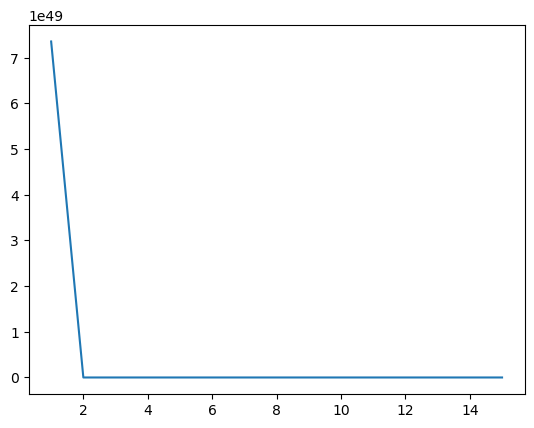

In [115]:
lr = 1e-3
epochs = 1000
# reduce the number of samples for faster training
losses = train(x_train[:100], x_train[:100], autoencoder, criterion, lr=lr, epochs=epochs)
plt.plot(losses)
plt.yscale('log')
plt.show()

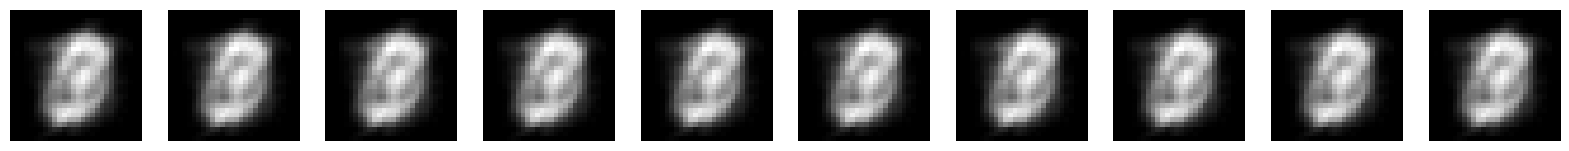

In [117]:
# final reconstructions
fig, axes = plt.subplots(1, 10, figsize=(20, 2))

for i, ax in enumerate(axes):
    # create one hot encoding for passing to decoder
    y = np.zeros((1, output_features))
    y[0, i] = 1
    
    x = autoencoder.decoder(y).reshape(28, 28)
    ax.imshow(x, cmap='gray')
    ax.axis('off')

plt.show()